In [ ]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

## Visualization Principles

Now that we have the tools to create and alter plots, we turn to key principles for data visualization. Much like other parts of data science, it is difficult to precisely assign a number that measures how effective a specific visualization is. Still, there are general principles that make visualizations much more effective at showing trends in the data. We discuss six categories of principles: scale, conditioning, perception, transformation, context, and smoothing.

### Principles of Scale

Principles of scale relate to the choice of x and y-axis used to plot the data.

In a 2015 US Congressional hearing, representative Chaffetz discussed an investigation of Planned Parenthood programs. He presented the following plot that originally appeared in a report by Americans United for Life. It compares the number of abortion and cancer screening procedures, both of which are offered by Planned Parenthood. (The full report is available at https://oversight.house.gov/interactivepage/plannedparenthood.)

What is suspicious about this plot? How many data points are plotted?

![viz_planned_parenthood.png](https://github.com/DS-100/textbook/raw/master/assets/viz_planned_parenthood.png)

This plot violates principles of scale; it doesn't make good choices for its x and y-axis.

When we select the x and y-axis for our plot, we should keep a consistent scale across the entire axis. However, the plot above has different scales for the Abortion and Cancer Screening lines—the start of the Abortion line and end of the Cancer Screening line lie close to each other on the y-axis but represent vastly different numbers. In addition, only points from 2006 and 2013 are plotted but the x-axis contains unnecessary tick marks for every year in between.

To improve this plot, we should re-plot the points on the same y-axis scale:

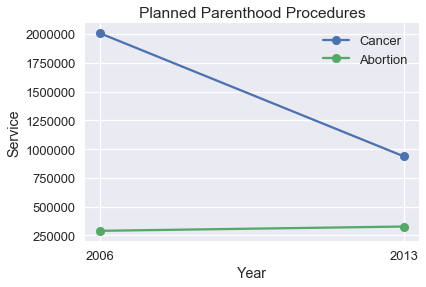

In [59]:
# HIDDEN
pp = pd.read_csv("data/plannedparenthood.csv")
plt.plot(pp['year'], pp['screening'], linestyle="solid", marker="o", label='Cancer')
plt.plot(pp['year'], pp['abortion'], linestyle="solid", marker="o", label='Abortion')
plt.title('Planned Parenthood Procedures')
plt.xlabel("Year")
plt.ylabel("Service")
plt.xticks([2006, 2013])
plt.legend();

We can see that the change in number of Abortions is very small compared to the large drop in the number of Cancer Screenings. Instead of the number of procedures, we might instead be interested in the percent change in number.

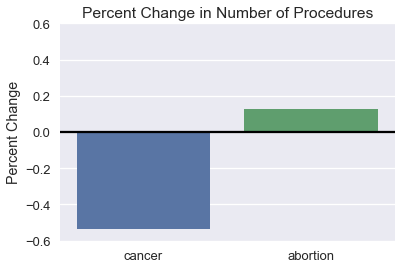

In [100]:
# HIDDEN
percent_change = pd.DataFrame({
    'percent_change': [
        pp['screening'].iloc[1] / pp['screening'].iloc[0] - 1,
        pp['abortion'].iloc[1] / pp['abortion'].iloc[0] - 1,
    ],
    'procedure': ['cancer', 'abortion'],
    'type': ['percent_change', 'percent_change'],
})
ax = sns.barplot(x='procedure', y='percent_change', data=percent_change)
plt.title('Percent Change in Number of Procedures')
plt.xlabel('')
plt.ylabel('Percent Change')
plt.ylim(-0.6, 0.6)
plt.axhline(y=0, c='black');

When selecting the x and y-axis limits we prefer to focus on the region with the bulk of the data, especially when working with long-tailed data. Consider the following plot and its zoomed in version to its right:

![viz_zoom.png](https://github.com/DS-100/textbook/raw/master/assets/viz_zoom.png)

The plot on the right is much more helpful for making sense of the dataset. If needed, we can make multiple plots of different regions of the data to show the entire range of data. Later in this section, we discuss data transformations which also help visualize long-tailed data.

### Principles of Conditioning

Principles of conditioning give us techniques to show distributions and relationships between subgroups of our data.

The US Bureau of Labor Statistics oversees scientific surveys related to the economic health of the US. Their website contains a tool to generate reports using this data that was used to generate this chart comparing median weekly earnings split by sex.

Which comparisons are easiest to make using this plot? Are these the comparisons that are most interesting or important?

![viz_earnings.png](https://github.com/DS-100/textbook/raw/master/assets/viz_earnings.png)

This plot lets us see at a glance that weekly earnings tend to increase with more education. However, it is difficult to tell exactly how much each level of education increases earnings and it is even more difficult to compare male and female weekly earnings at the same education level. We can uncover both these trends by using a dot chart instead of a bar chart.

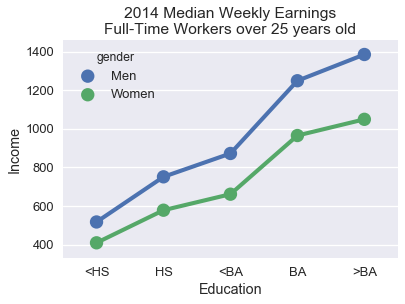

In [65]:
# HIDDEN
cps = pd.read_csv("data/edInc2.csv")
ax = sns.pointplot(x="educ", y="income", hue="gender", data=cps)

ticks = ["<HS", "HS", "<BA", "BA", ">BA"]
ax.set_xticklabels(ticks)
ax.set_xlabel("Education")
ax.set_ylabel("Income")
ax.set_title("2014 Median Weekly Earnings\nFull-Time Workers over 25 years old");

The lines connecting the points more clearly shows the relatively large effect of having a BA degree on weekly earnings. Placing the points for males and females directly above each other makes it much easier to see that the wage gap between males and females tends to increase with higher education levels.

To aid comparison of two subgroups within your data, align markers along the x or y-axis and use different colors or markers for different subgroups. Lines tend to show trends in data more clearly than bars and are a useful choice for both ordinal and numerical data.

### Principles of Perception

Human perception has specific properties that are important to consider in visualization design. The first important property of human perception is that we perceive some colors more strongly than others, especially green colors. In addition, we perceive lighter shaded areas as larger than darker shaded ones. For example, in the weekly earnings plot that we just discussed, the lighter bars seem to draw more attention than the darker colored ones:

![viz_earnings.png](https://github.com/DS-100/textbook/raw/master/assets/viz_earnings.png)

Practically speaking, you should ensure that your charts' color palettes are *perceptually uniform*. This means that, for example, the perceived intensity of the color won't change in between bars in a bar chart. For quantitative data, you have two choices: if your data progress from low to high and you want to emphasize large values, use a *sequential* color scheme which assigns lighter colors to large values. If both low and high values should be emphasized, use a *diverging* color scheme which assigns ligher colors to values closer to the center.

`seaborn` comes with many useful color palettes built-in. You can browse its documentation to learn how to switch between color palettes: http://seaborn.pydata.org/tutorial/color_palettes.html

A second important property of human perception is that we are generally more accurate when we compare lengths and less accurate when we compare areas. Consider the following chart of the GDP of African countries.

![viz_gdp.png](https://github.com/DS-100/textbook/raw/master/assets/viz_gdp.png)

By numerical value, South Africa has twice the GDP of Algeria but it's not easy to tell from the plot above. Instead, we can plot the GDPs on a dot plot:

![viz_gdp_v2.png](https://github.com/DS-100/textbook/raw/master/assets/viz_gdp_v2.png)

This is much more clear because it allows us to compare lengths instead of areas. Pie charts and three-dimensional charts are difficult to interpret for the same reason; we tend to avoid these charts in practice.

Our third and final property of perception is that the human eye has difficulty with changing baselines. Consider the following stacked area chart that plots carbon dioxide emissions over time split by country.

![https://github.com/DS-100/textbook/raw/master/assets/viz_emissions.png](https://github.com/DS-100/textbook/raw/master/assets/viz_emissions.png)

It is difficult to see whether the UK's emissions have increased or decreased over time because the of *jiggling baseline* problem: the baseline (bottom line) of the area jiggles up and down. It is also difficult to compare whether the UK's emissions are greater than China's emissions when the two heights are similar (in year 2000, for example).

Similar issues of jiggling baselines appear in stacked bar charts. In the plot below, it is difficult to compare the number of 15-64 year olds between Germany and Mexico.

![https://github.com/DS-100/textbook/raw/master/assets/viz_bar_stacked.jpeg](https://github.com/DS-100/textbook/raw/master/assets/viz_bar_stacked.jpeg)

We can often improve a stacked area or bar chart by switching to a line chart. Here's the data of emissions over time plotted as lines instead of areas:

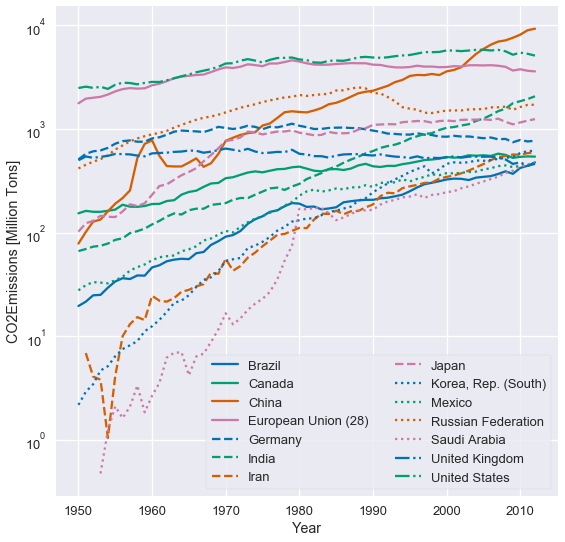

In [99]:
# HIDDEN
co2 = pd.read_csv("data/CAITcountryCO2.csv", skiprows = 2,
                  names = ["Country", "Year", "CO2"])
last_year = co2.Year.iloc[-1]
q = f"Country != 'World' and Country != 'European Union (15)' and Year == {last_year}"
top14_lasty = co2.query(q).sort_values('CO2', ascending=False).iloc[:14]
top14 = co2[co2.Country.isin(top14_lasty.Country) & (co2.Year >= 1950)]

from cycler import cycler

linestyles = (['-', '--', ':', '-.']*3)[:7]
colors = sns.color_palette('colorblind')[:4]
lines_c = cycler('linestyle', linestyles)
color_c = cycler('color', colors)

fig, ax = plt.subplots(figsize=(9, 9))
ax.set_prop_cycle(lines_c * color_c)

x, y ='Year', 'CO2'
for name, df in top14.groupby('Country'):
    ax.semilogy(df[x], df[y], label=name)

ax.set_xlabel(x)
ax.set_ylabel(y + "Emissions [Million Tons]")
ax.legend(ncol=2, frameon=True);

This plot does not jiggle the baseline so it is much easier to compare emissions between countries. We can also more clearly see which countries increased emissions the most.